In [115]:
#导入相关包
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
#设置sns样式
sns.set(style='white',context='notebook',palette='muted')
import matplotlib.pyplot as plt
#导入数据
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

理解数据

In [116]:
#分别查看实验数据集和预测数据集数据
print('实验数据大小:',train.shape)
print('预测数据大小:',test.shape)

实验数据大小: (891, 12)
预测数据大小: (418, 11)


该数据集共1309条数据，其中实验数据891条，预测数据418条；实验数据比预测数据多了一列：即标签"result"。

记录数据异常值、缺失值情况，方便下一步进行数据预处理。

In [117]:
#将实验数据和预测数据合并
full=train.append(test,ignore_index=True)
full.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


无明显的异常值，几乎所有数据均在正常范围内。

In [118]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


Age/Cabin/Embarked/Fare四项数据有缺失值，其中Cabin字段缺失近四分之三的数据。

结合图表查看各个特征与标签间的关系：

 Embarked与Survived：法国登船的乘客生存率较高

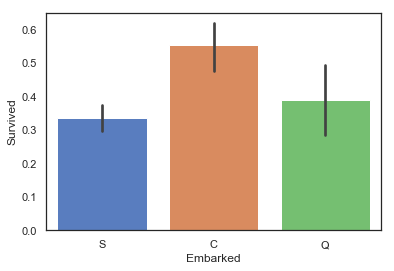

In [119]:
sns.barplot(data=train,x='Embarked',y='Survived')

In [120]:
#计算不同类型embarked的乘客，其生存率为多少
print('Embarked为"S"的乘客，其生存率为%.2f'%full['Survived'][full['Embarked']=='S'].value_counts(normalize=True)[1])
print('Embarked为"C"的乘客，其生存率为%.2f'%full['Survived'][full['Embarked']=='C'].value_counts(normalize=True)[1])
print('Embarked为"Q"的乘客，其生存率为%.2f'%full['Survived'][full['Embarked']=='Q'].value_counts(normalize=True)[1])

Embarked为"S"的乘客，其生存率为0.34
Embarked为"C"的乘客，其生存率为0.55
Embarked为"Q"的乘客，其生存率为0.39


法国登船乘客生存率较高原因可能与其头等舱乘客比例较高有关，因此继续查看不同登船地点乘客各舱位乘客数量情况。

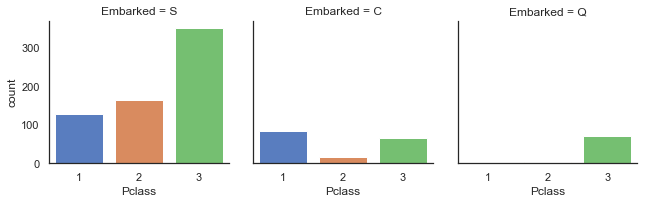

In [121]:
#法国登船乘客生存率较高原因可能与其头等舱乘客比例较高有关
sns.factorplot('Pclass',col='Embarked',data=train,kind='count',size=3)

果然，法国登船的乘客其头等舱所占比例更高

Parch与Survived：当乘客同行的父母及子女数量适中时，生存率较高

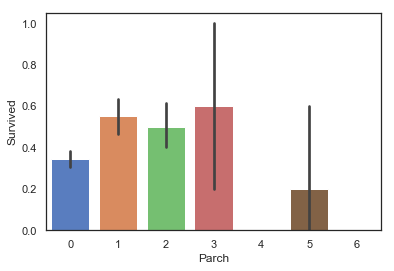

In [122]:
sns.barplot(data=train,x='Parch',y='Survived')

SibSp与Survived：当乘客同行的同辈数量适中时生存率较高

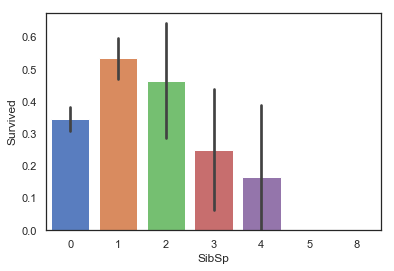

In [123]:
sns.barplot(data=train,x='SibSp',y='Survived')

Pclass与Survived：乘客客舱等级越高，生存率越高

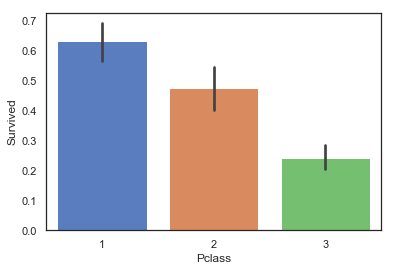

In [124]:
sns.barplot(data=train,x='Pclass',y='Survived')

Sex与Survived：女性的生存率远高于男性

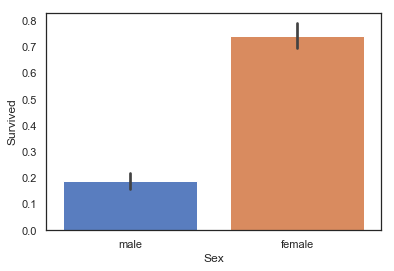

In [125]:
sns.barplot(data=train,x='Sex',y='Survived')

Age与Survived：当乘客年龄段在0-10岁期间时生存率会较高

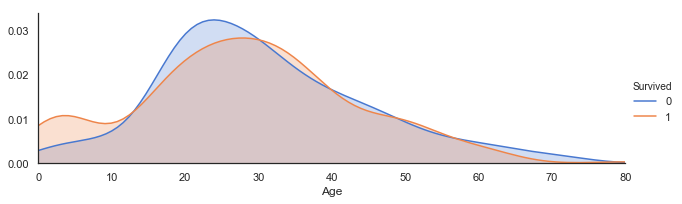

In [126]:
#创建坐标轴
ageFacet=sns.FacetGrid(train,hue='Survived',aspect=3)
#作图，选择图形类型
ageFacet.map(sns.kdeplot,'Age',shade=True)
#其他信息：坐标轴范围、标签等
ageFacet.set(xlim=(0,train['Age'].max()))
ageFacet.add_legend()

Fare与Survived：当票价低于18左右时乘客生存率较低，票价越高生存率一般越高

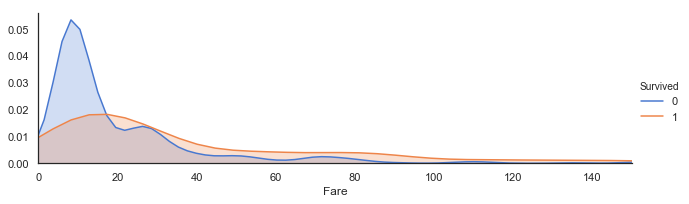

In [127]:
#创建坐标轴
ageFacet=sns.FacetGrid(train,hue='Survived',aspect=3)
ageFacet.map(sns.kdeplot,'Fare',shade=True)
ageFacet.set(xlim=(0,150))
ageFacet.add_legend()

查看票价的分布特征

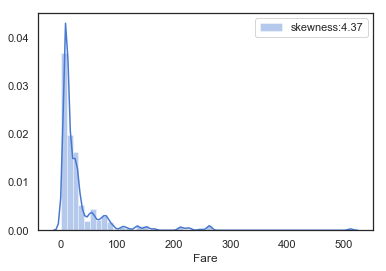

In [128]:
#查看fare分布
farePlot=sns.distplot(full['Fare'][full['Fare'].notnull()],label='skewness:%.2f'%(full['Fare'].skew()))
farePlot.legend(loc='best')

fare的分布呈左偏的形态，其偏度skewness=4.37较大，说明数据偏移平均值较多，因此我们需要对数据进行对数化处理，防止数据权重分布不均匀。

In [129]:
#对数化处理fare值
full['Fare']=full['Fare'].map(lambda x: np.log(x) if x>0 else 0)

数据预处理

Cabin缺失值填充

In [130]:
#对Cabin缺失值进行处理，利用U（Unknown）填充缺失值
full['Cabin']=full['Cabin'].fillna('U')
full['Cabin'].head()

0       U
1     C85
2       U
3    C123
4       U
Name: Cabin, dtype: object

Embarked缺失值填充

In [131]:
#对Embarked缺失值进行处理，查看缺失值情况
full[full['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,4.382027,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,4.382027,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


查看Embarked数据分布情况，可知在英国南安普顿登船可能性最大，因此以此填充缺失值。

In [132]:
full['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [133]:
full['Embarked']=full['Embarked'].fillna('S')

Fare缺失值填充

In [134]:
#查看缺失数据情况，该乘客乘坐3等舱，登船港口为法国，舱位未知
full[full['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket


利用3等舱，登船港口为英国，舱位未知旅客的平均票价来填充缺失值。

In [135]:
full['Fare']=full['Fare'].fillna(full[(full['Pclass']==3)&(full['Embarked']=='S')&(full['Cabin']=='U')]['Fare'].mean())

特征工程

 Name中的头衔信息-Title

In [136]:
#构造新特征Title
full['Title']=full['Name'].map(lambda x:x.split(',')[1].split('.')[0].strip())
#查看title数据分布
full['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Major             2
Mlle              2
Lady              1
Capt              1
Dona              1
Jonkheer          1
Don               1
Mme               1
the Countess      1
Sir               1
Name: Title, dtype: int64

将相近的Title信息整合在一起：

In [137]:
#将title信息进行整合
TitleDict={}
TitleDict['Mr']='Mr'
TitleDict['Mlle']='Miss'
TitleDict['Miss']='Miss'
TitleDict['Master']='Master'
TitleDict['Jonkheer']='Master'
TitleDict['Mme']='Mrs'
TitleDict['Ms']='Mrs'
TitleDict['Mrs']='Mrs'
TitleDict['Don']='Royalty'
TitleDict['Sir']='Royalty'
TitleDict['the Countess']='Royalty'
TitleDict['Dona']='Royalty'
TitleDict['Lady']='Royalty'
TitleDict['Capt']='Officer'
TitleDict['Col']='Officer'
TitleDict['Major']='Officer'
TitleDict['Dr']='Officer'
TitleDict['Rev']='Officer'

full['Title']=full['Title'].map(TitleDict)
full['Title'].value_counts()

Mr         757
Miss       262
Mrs        200
Master      62
Officer     23
Royalty      5
Name: Title, dtype: int64

可视化观察新特征与标签间关系

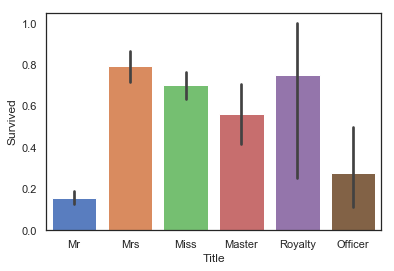

In [138]:
#可视化分析Title与Survived之间关系
sns.barplot(data=full,x='Title',y='Survived')

头衔为'Mr'及'Officer'的乘客，生存率明显较低。

FamilyNum及FamilySize信息

将Parch及SibSp字段整合得到一名乘客同行家庭成员总人数FamilyNum的字段，再根据家庭成员具体人数的多少得到家庭规模FamilySize这个新字段。

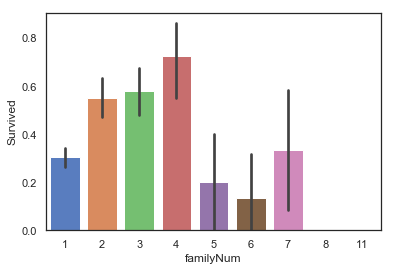

In [139]:
full['familyNum']=full['Parch']+full['SibSp']+1
#查看familyNum与Survived
sns.barplot(data=full,x='familyNum',y='Survived')

家庭成员人数在2-4人时，乘客的生存率较高，当没有家庭成员同行或家庭成员人数过多时生存率较低。

In [140]:
#我们按照家庭成员人数多少，将家庭规模分为“小、中、大”三类：
def familysize(familyNum):
    if familyNum==1:
        return 0
    elif (familyNum>=2)&(familyNum<=4):
        return 1
    else:
        return 2

full['familySize']=full['familyNum'].map(familysize)
full['familySize'].value_counts()

0    790
1    437
2     82
Name: familySize, dtype: int64

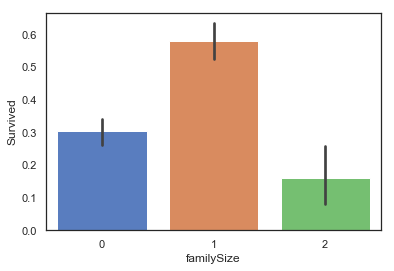

In [141]:
#查看familySize与Survived
sns.barplot(data=full,x='familySize',y='Survived')

当家庭规模适中时，乘客的生存率更高。

Cabin客舱类型信息-Deck

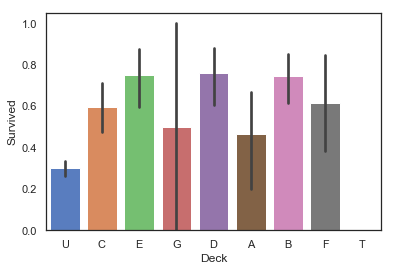

In [142]:
#提取Cabin字段首字母
full['Deck']=full['Cabin'].map(lambda x:x[0])
#查看不同Deck类型乘客的生存率
sns.barplot(data=full,x='Deck',y='Survived')

当乘客的客舱类型为B/D/E时，生存率较高；当客舱类型为U/T时，生存率较低。

共票号乘客数量TickCot及TickGroup

In [143]:
#提取各票号的乘客数量
TickCountDict={}
TickCountDict=full['Ticket'].value_counts()
TickCountDict.head()

CA. 2343        11
1601             8
CA 2144          8
S.O.C. 14879     7
347082           7
Name: Ticket, dtype: int64

In [144]:
#将同票号乘客数量数据并入数据集中
full['TickCot']=full['Ticket'].map(TickCountDict)
full['TickCot'].head()

0    1
1    2
2    1
3    2
4    1
Name: TickCot, dtype: int64

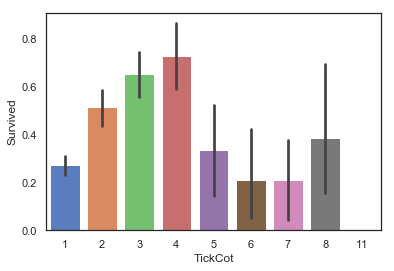

In [145]:
#查看TickCot与Survived之间关系
sns.barplot(data=full,x='TickCot',y='Survived')

当TickCot大小适中时，乘客生存率较高。

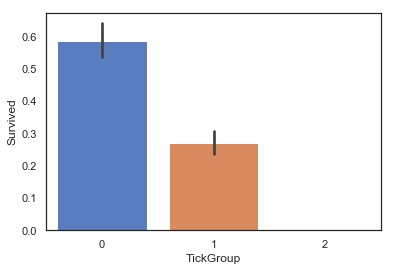

In [146]:
#按照TickCot大小，将TickGroup分为三类。
def TickCountGroup(num):
    if (num>=2)&(num<=4):
        return 0
    elif (num==1)|((num>=5)&(num<=8)):
        return 1
    else :
        return 2
#得到各位乘客TickGroup的类别
full['TickGroup']=full['TickCot'].map(TickCountGroup)
#查看TickGroup与Survived之间关系
sns.barplot(data=full,x='TickGroup',y='Survived')


Age缺失值填充-构建随机森林模型预测缺失的数据

查看Age与Parch、Pclass、Sex、SibSp、Title、familyNum、familySize、Deck、TickCot、TickGroup等变量的相关系数大小，筛选出相关性较高的变量构建预测模型。

In [147]:
#查看缺失值情况
full[full['Age'].isnull()].head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,familyNum,familySize,Deck,TickCot,TickGroup
5,NaN,U,Q,2.135148,"Moran, Mr. James",0,6,3,male,0,0.0,330877,Mr,1,0,U,1,1
17,NaN,U,S,2.564949,"Williams, Mr. Charles Eugene",0,18,2,male,0,1.0,244373,Mr,1,0,U,1,1
19,NaN,U,C,1.977547,"Masselmani, Mrs. Fatima",0,20,3,female,0,1.0,2649,Mrs,1,0,U,1,1
26,NaN,U,C,1.977547,"Emir, Mr. Farred Chehab",0,27,3,male,0,0.0,2631,Mr,1,0,U,1,1
28,NaN,U,Q,2.064226,"O'Dwyer, Miss. Ellen ""Nellie""",0,29,3,female,0,1.0,330959,Miss,1,0,U,1,1


In [148]:
#筛选数据集
AgePre=full[['Age','Parch','Pclass','SibSp','Title','familyNum','TickCot']]
#进行one-hot编码
AgePre=pd.get_dummies(AgePre)
ParAge=pd.get_dummies(AgePre['Parch'],prefix='Parch')
SibAge=pd.get_dummies(AgePre['SibSp'],prefix='SibSp')
PclAge=pd.get_dummies(AgePre['Pclass'],prefix='Pclass')
#查看变量间相关性
AgeCorrDf=pd.DataFrame()
AgeCorrDf=AgePre.corr()
AgeCorrDf['Age'].sort_values()

Pclass          -0.408106
Title_Master    -0.385380
Title_Miss      -0.282977
SibSp           -0.243699
familyNum       -0.240229
TickCot         -0.185284
Parch           -0.150917
Title_Royalty    0.057337
Title_Officer    0.166771
Title_Mr         0.183965
Title_Mrs        0.215091
Age              1.000000
Name: Age, dtype: float64

In [149]:
#拼接数据
AgePre=pd.concat([AgePre,ParAge,SibAge,PclAge],axis=1)
AgePre.head()

,Age,Parch,Pclass,SibSp,familyNum,TickCot,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Pclass_1,Pclass_2,Pclass_3
0,22.0,0,3,1,2,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
1,38.0,0,1,1,2,2,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
2,26.0,0,3,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
3,35.0,0,1,1,2,2,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,35.0,0,3,0,1,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


In [150]:
#拆分实验集和预测集
AgeKnown=AgePre[AgePre['Age'].notnull()]
AgeUnKnown=AgePre[AgePre['Age'].isnull()]

#生成实验数据的特征和标签
AgeKnown_X=AgeKnown.drop(['Age'],axis=1)
AgeKnown_y=AgeKnown['Age']
#生成预测数据的特征
AgeUnKnown_X=AgeUnKnown.drop(['Age'],axis=1)

#利用随机森林构建模型
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(random_state=None,n_estimators=500,n_jobs=-1)
rfr.fit(AgeKnown_X,AgeKnown_y)

#模型得分
rfr.score(AgeKnown_X,AgeKnown_y)

0.5871983055325247

In [151]:
#预测年龄
AgeUnKnown_y=rfr.predict(AgeUnKnown_X)
#填充预测数据
full.loc[full['Age'].isnull(),['Age']]=AgeUnKnown_y
full.info()  #此时已无缺失值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 18 columns):
Age            1309 non-null float64
Cabin          1309 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Title          1309 non-null object
familyNum      1309 non-null int64
familySize     1309 non-null int64
Deck           1309 non-null object
TickCot        1309 non-null int64
TickGroup      1309 non-null int64
dtypes: float64(3), int64(8), object(7)
memory usage: 184.2+ KB


虽然通过分析数据已有特征与标签的关系可以构建有效的预测模型，但是部分具有明显共同特征的用户可能与整体模型逻辑并不一致。如果将这部分具有同组效应的用户识别出来并对其数据加以修正，就可以有效提高模型的准确率。在Titancic案例中，我们主要探究相同姓氏的乘客是否存在明显的同组效应。

提取两部分数据，分别查看其“姓氏”是否存在同组效应（因为性别和年龄与乘客生存率关系最为密切，因此用这两个特征作为分类条件）：

12岁以上男性：找出男性中同姓氏均获救的部分；
女性以及年龄在12岁以下儿童：找出女性及儿童中同姓氏均遇难的部分。


In [152]:
#提取乘客的姓氏及相应的乘客数
full['Surname']=full['Name'].map(lambda x:x.split(',')[0].strip())
SurNameDict={}
SurNameDict=full['Surname'].value_counts()
full['SurnameNum']=full['Surname'].map(SurNameDict)

#将数据分为两组
MaleDf=full[(full['Sex']=='male')&(full['Age']>12)&(full['familyNum']>=2)]
FemChildDf=full[((full['Sex']=='female')|(full['Age']<=12))&(full['familyNum']>=2)]

In [153]:
#分析男性同组效应
MSurNamDf=MaleDf['Survived'].groupby(MaleDf['Surname']).mean()
MSurNamDf.head()
MSurNamDf.value_counts()

0.0    89
1.0    19
0.5     3
Name: Survived, dtype: int64

大多数同姓氏的男性存在“同生共死”的特点，因此利用该同组效应，我们对生存率为1的姓氏里的男性数据进行修正，提升其预测为“可以幸存”的概率。

In [154]:
#获得生存率为1的姓氏
MSurNamDict={}
MSurNamDict=MSurNamDf[MSurNamDf.values==1].index
MSurNamDict

Index(['Beane', 'Beckwith', 'Bishop', 'Cardeza', 'Chambers', 'Dick',
       'Duff Gordon', 'Frauenthal', 'Frolicher-Stehli', 'Goldenberg',
       'Greenfield', 'Harder', 'Hoyt', 'Kimball', 'Lindqvist', 'McCoy',
       'Nakid', 'Persson', 'Taylor'],
      dtype='object', name='Surname')

In [155]:
#分析女性及儿童同组效应
FCSurNamDf=FemChildDf['Survived'].groupby(FemChildDf['Surname']).mean()
FCSurNamDf.head()
FCSurNamDf.value_counts()

1.000000    115
0.000000     27
0.750000      2
0.333333      1
0.142857      1
Name: Survived, dtype: int64

与男性组特征相似，女性及儿童也存在明显的“同生共死”的特点，因此利用同组效应，对生存率为0的姓氏里的女性及儿童数据进行修正，提升其预测为“并未幸存”的概率。

In [156]:
#获得生存率为0的姓氏
FCSurNamDict={}
FCSurNamDict=FCSurNamDf[FCSurNamDf.values==0].index
FCSurNamDict

Index(['Ahlin', 'Arnold-Franchi', 'Barbara', 'Boulos', 'Bourke', 'Caram',
       'Danbom', 'Ford', 'Goodwin', 'Ilmakangas', 'Johnston', 'Jussila',
       'Lahtinen', 'Lefebre', 'Lobb', 'Palsson', 'Panula', 'Rice', 'Robins',
       'Rosblom', 'Sage', 'Skoog', 'Strom', 'Turpin', 'Van Impe',
       'Vander Planke', 'Zabour'],
      dtype='object', name='Surname')

对数据集中这些姓氏的两组数据数据分别进行修正：

男性数据修正为：1、性别改为女；2、年龄改为5；

女性及儿童数据修正为：1、性别改为男；2、年龄改为60。

In [157]:
#对数据集中这些姓氏的男性数据进行修正：1、性别改为女；2、年龄改为5。
full.loc[(full['Survived'].isnull())&(full['Surname'].isin(MSurNamDict))&(full['Sex']=='male'),'Age']=5
full.loc[(full['Survived'].isnull())&(full['Surname'].isin(MSurNamDict))&(full['Sex']=='male'),'Sex']='female'

#对数据集中这些姓氏的女性及儿童的数据进行修正：1、性别改为男；2、年龄改为60。
full.loc[(full['Survived'].isnull())&(full['Surname'].isin(FCSurNamDict))&((full['Sex']=='female')|(full['Age']<=12)),'Age']=60
full.loc[(full['Survived'].isnull())&(full['Surname'].isin(FCSurNamDict))&((full['Sex']=='female')|(full['Age']<=12)),'Sex']='male'

在对数据进行分析处理的过程中，数据的维度更高了，为提升数据有效性需要对数据进行降维处理。通过找出与乘客生存率“Survived”相关性更高的特征，剔除重复的且相关性较低的特征，从而实现数据降维。

In [158]:
#人工筛选
fullSel=full.drop(['Cabin','Name','Ticket','PassengerId','Surname','SurnameNum'],axis=1)
#查看各特征与标签的相关性
corrDf=pd.DataFrame()
corrDf=fullSel.corr()
corrDf['Survived'].sort_values(ascending=True)

Pclass       -0.338481
TickGroup    -0.319278
Age          -0.059353
SibSp        -0.035322
familyNum     0.016639
TickCot       0.064962
Parch         0.081629
familySize    0.108631
Fare          0.331805
Survived      1.000000
Name: Survived, dtype: float64

通过热力图，查看Survived与其他特征间相关性大小。

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text xticklabel objects>)

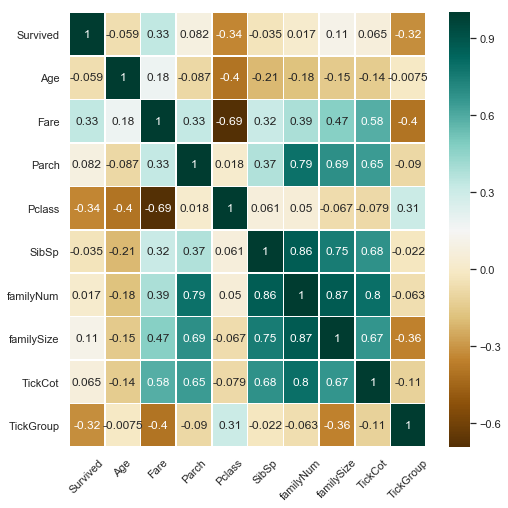

In [159]:
#热力图，查看Survived与其他特征间相关性大小
plt.figure(figsize=(8,8))
sns.heatmap(fullSel[['Survived','Age','Embarked','Fare','Parch','Pclass',
                    'Sex','SibSp','Title','familyNum','familySize','Deck',
                     'TickCot','TickGroup']].corr(),cmap='BrBG',annot=True,
           linewidths=.5)
plt.xticks(rotation=45)

先人工初步筛除与标签预测明显不相关或相关度很低的特征，再查看剩余特征与标签之间的相关性大小做进一步降维。

In [160]:
fullSel=fullSel.drop(['familyNum','SibSp','TickCot','Parch'],axis=1)
#one-hot编码
fullSel=pd.get_dummies(fullSel)
PclassDf=pd.get_dummies(full['Pclass'],prefix='Pclass')
TickGroupDf=pd.get_dummies(full['TickGroup'],prefix='TickGroup')
familySizeDf=pd.get_dummies(full['familySize'],prefix='familySize')

fullSel=pd.concat([fullSel,PclassDf,TickGroupDf,familySizeDf],axis=1)

In [161]:
#拆分实验数据与预测数据
experData=fullSel[fullSel['Survived'].notnull()]
preData=fullSel[fullSel['Survived'].isnull()]

experData_X=experData.drop('Survived',axis=1)
experData_y=experData['Survived']
preData_X=preData.drop('Survived',axis=1)

#导入机器学习算法库
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold

#设置kfold，交叉采样法拆分数据集
kfold=StratifiedKFold(n_splits=10)

#汇总不同模型算法
classifiers=[]
classifiers.append(SVC())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(ExtraTreesClassifier())
classifiers.append(GradientBoostingClassifier())
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression())
classifiers.append(LinearDiscriminantAnalysis())

比较各种算法结果，进一步选择模型

In [162]:
#不同机器学习交叉验证结果汇总
cv_results=[]
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier,experData_X,experData_y,
                                      scoring='accuracy',cv=kfold,n_jobs=-1))

求出模型得分的均值和标准差

In [163]:
#求出模型得分的均值和标准差
cv_means=[]
cv_std=[]
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
#汇总数据
cvResDf=pd.DataFrame({'cv_mean':cv_means,
                     'cv_std':cv_std,
                     'algorithm':['SVC','DecisionTreeCla','RandomForestCla','ExtraTreesCla',
                                  'GradientBoostingCla','KNN','LR','LinearDiscrimiAna']})

cvResDf

,cv_mean,cv_std,algorithm
0,0.829410,0.040698,SVC
1,0.786850,0.045750,DecisionTreeCla
2,0.812555,0.043477,RandomForestCla
3,0.799135,0.043156,ExtraTreesCla
4,0.839534,0.039110,GradientBoostingCla
5,0.798085,0.040520,KNN
6,0.828298,0.029173,LR
7,0.823841,0.027174,LinearDiscrimiAna


可视化查看不同算法的表现情况

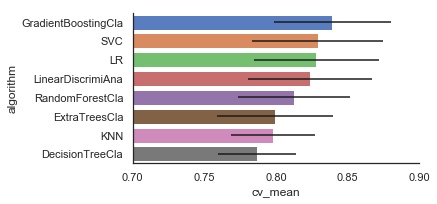

In [164]:
# sns.barplot(data=cvResDf,x='cv_mean',y='algorithm',**{'xerr':cv_std})

cvResFacet=sns.FacetGrid(cvResDf.sort_values(by='cv_mean',ascending=False),sharex=False,
            sharey=False,aspect=2)
cvResFacet.map(sns.barplot,'cv_mean','algorithm',**{'xerr':cv_std},
               palette='muted')
cvResFacet.set(xlim=(0.7,0.9))
cvResFacet.add_legend()

综合以上模型表现，考虑选择GradientBoostingCla、LR、RandomForestCla三种模型进一步对比。

分别建立GradientBoostingClassifier,LogisticRegression以及RandomForestClassifier模型，并进行模型调优。

In [165]:
#GradientBoostingClassifier模型
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1]
              }
modelgsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, 
                                     scoring="accuracy", n_jobs= -1, verbose = 1)
modelgsGBC.fit(experData_X,experData_y)
print(modelgsGBC.best_params_,modelgsGBC.best_score_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   12.8s finished


{'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 4, 'max_features': 0.3, 'min_samples_leaf': 150, 'n_estimators': 300} 0.8428731762065096


In [166]:
#LogisticRegression模型
LR=LogisticRegression()
LR_param_grid = {'C' : [1,2,3],
                'penalty':['l1','l2']}
modelgsLR = GridSearchCV(LR,param_grid = LR_param_grid, cv=kfold,
                                     scoring="accuracy", n_jobs= -1, verbose = 1)
modelgsLR.fit(experData_X,experData_y)
print(modelgsLR.best_params_,modelgsLR.best_score_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.1s finished


{'C': 1, 'penalty': 'l1'} 0.8316498316498316


In [167]:
RFC=RandomForestClassifier(max_features ='sqrt',
                  random_state=10,warm_start=True)
RFC_param_grid = {'n_estimators':list(range(20,40,1)),
                'max_depth':list(range(3,20,2))
                  }
modelRFC = GridSearchCV(RFC,param_grid =RFC_param_grid, cv=kfold,
                                     scoring="accuracy", n_jobs= -1, verbose = 1)
modelRFC.fit(experData_X,experData_y)
print(modelRFC.best_params_,modelRFC.best_score_)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 335 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1335 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:   14.1s finished


{'max_depth': 7, 'n_estimators': 22} 0.8383838383838383


In [178]:
from sklearn.ensemble import VotingClassifier
GBC1=GradientBoostingClassifier(learning_rate= 0.1, loss='deviance', max_depth=4, max_features=0.3, min_samples_leaf=150, n_estimators=300)
LR1=LogisticRegression(C=1, penalty='l1')
RFC1=RandomForestClassifier(max_depth=7, n_estimators=22,max_features ='sqrt',
                  random_state=10,warm_start=True)
eclf1 = VotingClassifier(estimators=[('gbc', GBC1), ('lr', LR1), ('rfc', RFC1)], voting='soft')
eclf1.fit(experData_X,experData_y)

VotingClassifier(estimators=[('gbc', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=150...estimators=22, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=True))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

查看模型准确度

In [179]:
#modelgsGBC模型
print('modelgsGBC模型得分为：%.3f'%modelgsGBC.best_score_)
#modelgsLR模型
print('modelgsLR模型得分为：%.3f'%modelgsLR.best_score_)
#modelRFC模型
print('modelRFC模型得分为：%.3f'%modelRFC.best_score_)
#混合模型
print('混合模型得分为：%.3f'%eclf1.score(experData_X,experData_y))

modelgsGBC模型得分为：0.843
modelgsLR模型得分为：0.832
modelRFC模型得分为：0.838
混合模型得分为：0.860


利用模型进行预测，并按规则导出预测结果。

In [180]:
#TitanicRFCmodle
preData_y=eclf1.predict(preData_X)
preData_y=preData_y.astype(int)
#导出预测结果
preResultDf=pd.DataFrame()
preResultDf['PassengerId']=full['PassengerId'][full['Survived'].isnull()]
preResultDf['Survived']=preData_y
preResultDf
#将预测结果导出为csv文件
preResultDf.to_csv('submission.csv',index=False)